<a href="https://colab.research.google.com/github/Namtk214/RNN-LSTM-GRU/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install unidecode

In [16]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
!gdown 1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q

Downloading...
From: https://drive.google.com/uc?id=1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
To: /content/dataset.zip
100% 230k/230k [00:00<00:00, 79.2MB/s]


In [18]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
replace dataset/all-data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dataset/all-data.csv    


In [19]:
dataset_path = 'dataset/all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(dataset_path, names=headers, encoding='ISO-8859-1')

In [20]:
classes = {
    class_name: idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())
}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])

PREPROCESSING


In [21]:
english_stopwords = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
    text = text.lower()
    text = unidecode.unidecode(text)
    text = text.strip()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = ' '.join([word for word in text.split() if word not in english_stopwords])
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [22]:
df['content'] = df['content'].apply(lambda x: text_normalize(x))

In [23]:
vocab = []
for sentences in df['content'].tolist():
    tokens = sentences.split()
    for token in tokens:
        if token not in vocab:
            vocab.append(token)

vocab.append('<PAD>')
vocab.append('<UNK>')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

In [24]:
def transform(text, word_to_idx, max_seq_len):
    tokens = []
    for w in text.split():
        try:
            w_ids = word_to_idx[w]
        except:
            w_ids = word_to_idx['<UNK>']
        tokens.append(w_ids)
    if len(tokens) < max_seq_len:
        tokens += [word_to_idx['<PAD>']] * (max_seq_len - len(tokens))
    elif len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]
    return tokens

DATASET PREPARING

In [25]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=val_size, shuffle=is_shuffle)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=test_size, shuffle=is_shuffle)

In [26]:
class FinancialNews(Dataset):
    def __init__(self, X, y, word_to_idx, max_seq_len, transform=None):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if self.transform:
            text = self.transform(text, self.word_to_idx, self.max_seq_len)
        text = torch.tensor(text)
        return text, label

In [27]:
max_seq_len = 32

train_dataset = FinancialNews(X_train, y_train, word_to_idx, max_seq_len, transform=transform)
val_dataset = FinancialNews(X_val, y_val, word_to_idx, max_seq_len, transform=transform)
test_dataset = FinancialNews(X_test, y_test, word_to_idx, max_seq_len, transform=transform)

train_batch_size = 128
test_batch_size = 8
val_batch_size = 8

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

RNN Model

In [28]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout_prob):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True, dropout=dropout_prob)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [29]:
n_classes = len(list(classes.keys()))
embedding_dim = 128
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SentimentClassifier(vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout_prob).to(device)



In [31]:
lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [32]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss = np.mean(losses)
    acc = correct / total
    return loss, acc

In [35]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, device):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            batch_train_losses.append(loss.item())

        train_loss = np.mean(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return train_losses, val_losses



In [36]:
train_losses, val_losses = fit(model, train_dataloader, val_dataloader, epochs, criterion, optimizer, device)

Epoch: 1/50, Train Loss: 0.9413, Val Loss: 0.8922, Val Acc: 0.6085
Epoch: 2/50, Train Loss: 0.9377, Val Loss: 0.8931, Val Acc: 0.6073
Epoch: 3/50, Train Loss: 0.9357, Val Loss: 0.8949, Val Acc: 0.6073
Epoch: 4/50, Train Loss: 0.9353, Val Loss: 0.8944, Val Acc: 0.6085
Epoch: 5/50, Train Loss: 0.9376, Val Loss: 0.8955, Val Acc: 0.6097
Epoch: 6/50, Train Loss: 0.9318, Val Loss: 0.8940, Val Acc: 0.6097
Epoch: 7/50, Train Loss: 0.9383, Val Loss: 0.8961, Val Acc: 0.6097
Epoch: 8/50, Train Loss: 0.9366, Val Loss: 0.8937, Val Acc: 0.6097
Epoch: 9/50, Train Loss: 0.9348, Val Loss: 0.8954, Val Acc: 0.6097
Epoch: 10/50, Train Loss: 0.9360, Val Loss: 0.8936, Val Acc: 0.6097
Epoch: 11/50, Train Loss: 0.9305, Val Loss: 0.8932, Val Acc: 0.6097
Epoch: 12/50, Train Loss: 0.9372, Val Loss: 0.8944, Val Acc: 0.6097
Epoch: 13/50, Train Loss: 0.9387, Val Loss: 0.8943, Val Acc: 0.6097
Epoch: 14/50, Train Loss: 0.9368, Val Loss: 0.8946, Val Acc: 0.6108
Epoch: 15/50, Train Loss: 0.9392, Val Loss: 0.8941, Val A

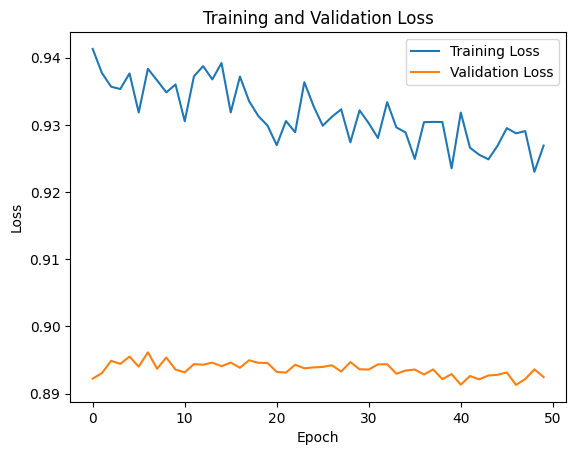

In [37]:

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [38]:
val_loss, val_acc = evaluate(model, val_dataloader, criterion, device)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


Validation Loss: 0.8925, Validation Accuracy: 0.6108
Test Loss: 0.9423, Test Accuracy: 0.5574
